# Vibe Coding a modern diffusion pipeline (NVIDIA EDM, SR3, Toyota SR)

* Nvidia - Elucidating the Design Space of Diffusion-Based Generative Models - https://arxiv.org/abs/2206.00364
* Toyota - Efficient Burst Super-Resolution with One-step Diffusion - https://arxiv.org/abs/2507.13607
* Google SR3 - Image Super-Resolution via Iterative Refinement - https://arxiv.org/abs/2104.07636


## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import base64
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
from io import BytesIO
from PIL import Image, ImageOps
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import io

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HR = 256
LR = 64
max_training_time = 60*5
display_interval = 30

# https://www.kaggle.com/datasets/chetankv/dogs-cats-images
# https://www.kaggle.com/datasets/nerfviking/fantasyscifi-full-body-character-concepts
# https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset
experiments = {
    "fantasy": ("./data/fantasy", "checkpoints/UNet128_2025-09-12_08-24-21_fantasy.pth", "checkpoints/UNetSR3_2025-09-14_17-32-01_fantasy.pth"),
    "cats_and_dogs": ("./data/cats_and_dogs/dataset/training_set", "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth",None),
    "pokemon": ("./data/pokemon_archive","UNet128_2025-09-12_11-03-12_pokemon.pth",None),
    "dragon": ("utils/dataset_fetcher/datasets/", "checkpoints/UNet128_2025-09-14_01-53-22_dragon.pth",None),
    "yugioh": ("data/yugioh/YuGiOhImages",None,None),
    "mnist": (None,None,None),
}

experiment_name = "fantasy"
src_data, diffusion_weights,checkpoint_weights = experiments[experiment_name]

## 3. Define a Vision Mmodel for a Diffusion Model Architecture

* **Sinusoidal Timestep Embedding**
  * → Encodes diffusion step (time) as a multi-frequency vector. Lets the model “know” how much noise is present and what stage of denoising it’s in.
* **Optional Self-Attention at Lower Resolutions (e.g. 16×16)**
  * → Lets distant parts of the image “talk to each other,” useful for global structure (symmetry, object coherence). Limited to low-res maps to save compute.
* **SiLU/Swish activations**
  * → Smooth nonlinearities, empirically better than ReLU in diffusion U-Nets.

In [17]:

# -----------------------------
# Positional embedding for timestep/sigma
# -----------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


# -----------------------------
# Simple self-attention block
# -----------------------------
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q, k, v = self.qkv(h).chunk(3, dim=1)
        q = q.reshape(B, C, H*W).permute(0, 2, 1)  # B, HW, C
        k = k.reshape(B, C, H*W)                    # B, C, HW
        attn = torch.bmm(q, k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        v = v.reshape(B, C, H*W).permute(0, 2, 1)
        h = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        return x + self.proj(h)


# -----------------------------
# Residual block with optional attention
# -----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(emb_dim, out_ch)
        if use_attention:
            self.attn = SelfAttention(out_ch)
        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, t_emb):
        h = F.relu(self.conv1(x))
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = F.relu(self.conv2(h))
        if self.use_attention:
            h = self.attn(h)
        return h + self.skip(x)


# -----------------------------
# 64x64 RGB U-Net (channel-corrected)
# -----------------------------
class UNet128(nn.Module):
    def __init__(self, in_channels=3, base_ch=64, emb_dim=128, use_attention=True):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )

        # Down path
        self.inc = ResBlock(in_channels, base_ch, emb_dim)
        self.down1 = ResBlock(base_ch, base_ch*2, emb_dim)
        self.down2 = ResBlock(base_ch*2, base_ch*4, emb_dim, use_attention=use_attention)
        self.down3 = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)
        self.pool = nn.AvgPool2d(2)

        # Middle
        self.mid = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        # Up path (channels corrected!)
        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 2, stride=2)
        self.up_block3 = ResBlock(base_ch*4 + base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.up_block2 = ResBlock(base_ch*2 + base_ch*4, base_ch*2, emb_dim)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.up_block1 = ResBlock(base_ch + base_ch*2, base_ch, emb_dim)
        
        self.up0 = nn.ConvTranspose2d(base_ch, base_ch, 2, stride=2)
        self.up_block0 = ResBlock(base_ch + base_ch, base_ch, emb_dim)

        # Output
        self.outc = nn.Conv2d(base_ch, in_channels, 1)

    def forward(self, x, t):
        #print("in forward",x.shape, t.shape)
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        t_emb = self.time_mlp(t)

        # Downsampling
        x1 = self.inc(x, t_emb)            # 64x64 -> 64x64
        x2 = self.down1(self.pool(x1), t_emb)  # 64->32
        x3 = self.down2(self.pool(x2), t_emb)  # 32->16
        x4 = self.down3(self.pool(x3), t_emb)  # 16->8

        # Middle
        m = self.mid(self.pool(x4), t_emb)     # 8->4
        #print("x shapes",x1.shape, x2.shape)
        # Upsampling
        u3 = self.up_block3(torch.cat([self.up3(m), x4], dim=1), t_emb)  # 4->8
        u2 = self.up_block2(torch.cat([self.up2(u3), x3], dim=1), t_emb) # 8->16
        u1 = self.up_block1(torch.cat([self.up1(u2), x2], dim=1), t_emb) # 16->32
        u0 = self.up_block0(torch.cat([self.up0(u1), x1], dim=1), t_emb) # 16->32

        # Final upsample to original size
        # The Chatbot's "u_final" here results in very noisy images.  Using u0 above is much better.
        #u_final = F.interpolate(u1, size=x.shape[-2:], mode='bilinear', align_corners=False)
        #print("shapes",u3.shape, u2.shape, u1.shape, u0.shape, u_final.shape, "hopefully the last 2 match")
        return self.outc(u0)


In [18]:
if show_model_info := False:
    model = UNet128(use_attention=True).to(device)
    print(model)

    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    from torchview import draw_graph
    model = UNet128(use_attention=True).to(device)
    x,t = torch.rand(12, 3, 64, 64), torch.rand(12)
    #print(x,t)
    model_graph = draw_graph(model, input_data=(x,t), device='meta')
    model_graph.visual_graph

    type(model_graph.visual_graph)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='svg', cleanup=True)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='pdf', cleanup=True)
    svg_data = model_graph.visual_graph.pipe(format='svg')
    #ipd.display(ipd.SVG(svg_data))
    del(model)



## 4. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

In [19]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.

from torch.utils.data import Dataset
import torch.nn.functional as F

class LRHRDataset(Dataset):
    """
    Wraps an existing dataset that returns [3,H,H] tensors in [-1,1],
    and produces:
      - hr: [3, HR, HR]
      - lr: [3, LR, LR]
      #- cond_lr_up [3, HR, HR] (LR downsampled to LR_SIZE then upsampled)
    """
    def __init__(self, hr_dataset, lr_size=LR, hr_size=HR):
        super().__init__()
        self.hr_dataset = hr_dataset
        self.lr_size = lr_size
        self.hr_size = hr_size

    def __len__(self):
        return len(self.hr_dataset)

    def __getitem__(self, idx):
        hr_img, _ = self.hr_dataset[idx]  # [3,HR,HR]
        # Ensure it's [3,HR,HR]
        hr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.hr_size, self.hr_size),
                               mode='bilinear', align_corners=False).squeeze(0)
        # Create LR then upscale
        lr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.lr_size, self.lr_size),
                               mode='bilinear', align_corners=False)
        #cond_lr_up = F.interpolate(lr_img, size=(self.hr_size, self.hr_size),
        #                           mode='bilinear', align_corners=False).squeeze(0)
        #return hr_img, cond_lr_up
        return hr_img, lr_img.squeeze(0)
    
def get_datasets(experiment_name):
    lr_transform = transforms.Compose([
            transforms.Resize((LR, LR)),
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=hr_transform)
    lr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=lr_transform)
    paired_dataset = LRHRDataset(hr_dataset)
    return lr_dataset,paired_dataset

lrds,paired = get_datasets('fantasy')


In [20]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.


def show_examples(experiment_name):
    train_dataset,paired_dataset = get_datasets(experiment_name)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    for i, img in enumerate(examples):
        # Unscale back to [0,1] for display
        img_disp = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
        axes[i].imshow(img_disp)
        axes[i].axis("off")
    plt.show()
    print(len(train_dataset))
#show_examples(experiment_name)

import torchvision
def show_lr_hr_pairs(paired_dataset, num=4):
    #train_dataset,paired_dataset = get_datasets(experiment_name)
    loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)

    fig, axes = plt.subplots(num, 2, figsize=(6, 3*num))
    for i in range(num):
        hr, lr_up = paired_dataset[i]

        # Convert from [-1,1] to [0,1] for visualization
        hr_vis = (hr * 0.5 + 0.5).clamp(0,1)
        lr_vis = (lr_up * 0.5 + 0.5).clamp(0,1)

        axes[i,1].imshow(torchvision.utils.make_grid(lr_vis).permute(1,2,0))
        axes[i,1].set_title("LR (upsampled)")
        axes[i,1].axis("off")

        axes[i,0].imshow(torchvision.utils.make_grid(hr_vis).permute(1,2,0))
        axes[i,0].set_title("HR")
        axes[i,0].axis("off")
    plt.tight_layout()
    plt.show()

    for hr_imgs, cond_lr_up in loader:
        print(hr_imgs.shape, cond_lr_up.shape)
        # Should print: torch.Size([4,3,128,128]) torch.Size([4,3,128,128])
        break
#show_lr_hr_pairs(get_datasets(experiment_name)[1])
#show_examples(experiment_name)



## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

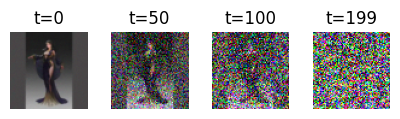

In [21]:
# Forward diffusion process

def illustrate_noising_process():
    device="cpu"
    T = 200  # Number of diffusion steps
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    def q_sample(x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

    # Visualize noisy images at different timesteps
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8
    x = examples[:4].to(device)  # batch of clean images
    timesteps = torch.tensor([0, T//4, T//2, T-1], device=device)

    noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]

    fig, axes = plt.subplots(1, 4, figsize=(5, 1))
    for i, img in enumerate(noisy_imgs):
        img_disp = img[0].detach().cpu()
        img_disp = (img_disp * 0.5 + 0.5).clamp(0, 1)   # unscale [-1,1] → [0,1]
        img_disp = img_disp.permute(1, 2, 0).numpy()   # CHW → HWC
        axes[i].imshow(img_disp)
        axes[i].set_title(f"t={timesteps[i].item()}")
        axes[i].axis('off')
    plt.show()
illustrate_noising_process()


## Checkpoint stuff

In [22]:
import torch
import os

import torch
import os
from datetime import datetime

def save_checkpoint(model, optimizer, epoch, loss, path=None, tag = ""):
    checkpoint = {
        "epoch": epoch,
        "loss": loss,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "model_class": model.__class__.__name__,
        "model_repr": str(model),  # optional: full repr for reference
    }

    if path is None:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        cls_name = model.__class__.__name__
        path = f"checkpoints/{cls_name}_{timestamp}_{tag}.pth"

    dir_name = os.path.dirname(path)
    if dir_name != "":
        os.makedirs(dir_name, exist_ok=True)

    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint: {path}")
    return path

def load_checkpoint(model, optimizer, path, map_location=None):
    checkpoint = torch.load(path, map_location=map_location or "cpu")
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"🔄 Loaded checkpoint from {path}")
    print(f"    Epoch: {checkpoint.get('epoch', '?')}, Loss: {checkpoint.get('loss', '?')}")
    print(f"    Model class: {checkpoint.get('model_class', '?')}")
    return model, optimizer, checkpoint




## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

In [23]:
# EDM noise schedule, loss weighting, and sampling procedure
# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2


if show_edm_schedule:=False:
    # Example: plot the EDM noise schedule
    ts = torch.linspace(0, 1, 100)
    sigmas = edm_sigma_schedule(ts)
    plt.plot(ts.numpy(), sigmas.numpy())
    plt.xlabel('t')
    plt.ylabel('sigma(t)')
    plt.title('EDM Noise Schedule')
    plt.show()

In [24]:
for x in [0.0, 0.25, 0.5, 0.75, 1.0]:
    print(x, edm_sigma_schedule(x))

0.0 80.0
0.25 17.52783196464411
0.5 2.515218976147159
0.75 0.16975275626876413
1.0 0.002000000000000003


### 6b. EDM Sampling / Reconstruction

In [25]:
# EDM sampling procedure - Following NVIDIA's edm_sampler (Algorithm 2)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")

In [26]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(model_edm, num_steps=15, batch_size=20, img_shape = (3,64,64)):
    to_pil = transforms.ToPILImage()
    with torch.no_grad():
        samples = edm_ancestral_sampling(model_edm, num_steps=num_steps, batch_size=batch_size, img_shape=(3, 64, 64)).cpu()
        samples = (samples + 1) / 2  # scale from [-1,1] to [0,1]
        samples = samples.clamp(0, 1)
        pil_images = [to_pil(img) for img in samples]
    return pil_images

def pil_to_data_url(pil_img):
    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def html_for_images(pil_images, min_height=64, title="Hi"):
    data_urls = [pil_to_data_url(img) for img in pil_images]
    html = f"""
    <h2>{title}</h2>
    <div style="display: flex; flex-wrap: wrap; gap: 2px;">
    """
    for url in data_urls:
        html += f"""
        <div style="flex: 0 0 auto;">
            <img src="{url}" style="min-width: {min_height}px;"/>
        </div>
        """
    html += "</div>"
    return html

def sample_html(model, batch_size=12, img_shape=(3,64,64), num_steps=36, title="EDM Samples",min_height=128):
    imgs = generate_images(model_edm=model, batch_size=batch_size, img_shape=img_shape, num_steps=16)
    h = html_for_images(imgs, title=title, min_height=min_height)
    return h


# 6c. EDM Training Loop 

In [27]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])
        F_x = model_edm(c_in * y_noisy, c_noise_input)
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        return loss.item()



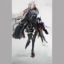
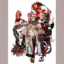
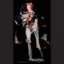
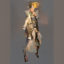
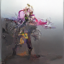
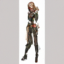
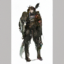
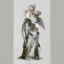
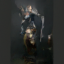
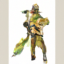
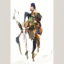
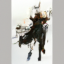

  0%|          | 0/101 [00:00<?, ?it/s]

✅ Saved checkpoint: checkpoints/UNet128_2025-09-14_17-47-44_fantasy.pth


'checkpoints/UNet128_2025-09-14_17-47-44_fantasy.pth'

In [28]:
def train_some(experiment_name):
    model_edm = UNet128(use_attention=True).to(device)
    optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume:=True and diffusion_weights:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=diffusion_weights)
    
    t0 = time.time()
    next_display_time = t0
    display_interval = 30
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = f"outputs/{experiment_name}_{timestamp}.html"
    os.makedirs("outputs", exist_ok=True)
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        if not os.path.exists("/tmp/training_running.txt"):
            break
        for x, _ in pbar:
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
            if time.time() > next_checkpoint_time:
                save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:
                next_display_time += display_interval
                dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                h = sample_html(model_edm,title=f"EDM at {dt} loss {loss:.4f} ({timestamp})")
                with open(path,"a") as f:
                    f.write(h)
                ipd.clear_output(wait=True)
                ipd.display(ipd.HTML(h))
    path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
    del model_edm,optimizer_edm
    return path

train_some(experiment_name)
        

## Inferrence

In [31]:
#diffusion_weights = "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth"
#diffusion_weights = "checkpoints/UNet128_2025-09-09_06-38-40_fantasy.pth"
#load_checkpoint(model_edm, optimizer_edm, diffusion_weights)

def generate_html_examples(cp="checkpoints/UNet128_2025-09-12_19-47-15_dragon.pth",batch_size=12):
    with torch.no_grad():
        model_edm = UNet128(use_attention=True).to(device)
        optimizer_edm = None
        load_checkpoint(model_edm, optimizer_edm, cp)
        h = sample_html(model_edm,title=f"Samples from {cp}",min_height=256, batch_size=batch_size)
        ipd.display(ipd.HTML(h))
        model_edm.to('cpu')
        



🔄 Loaded checkpoint from checkpoints/UNet128_2025-09-14_02-20-07_fantasy.pth
    Epoch: 2, Loss: 0.08024808764457703
    Model class: UNet128



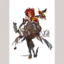
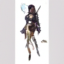
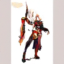
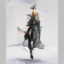
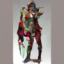
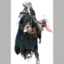

In [49]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-20-07_fantasy.pth",batch_size=6)

🔄 Loaded checkpoint from checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth
    Epoch: 1, Loss: 0.1339804232120514
    Model class: UNet128



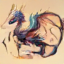
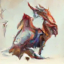
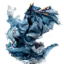
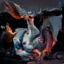
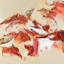
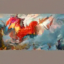

In [43]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth",batch_size=6)

## Pytorch memory management for a 6GB card:

In [80]:
import objgraph
import torch
import gc

if debug_leaking_tensors := False:
    gc.collect()
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary()) 


    # Find one lingering tensor
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(f"Found tensor: {type(obj)}, size: {obj.size()}")
            result = objgraph.show_backrefs([obj], max_depth=3)
            ipd.display(result)
            break

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
        except:
            pass


In [81]:
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary()) 


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 7            |        cudaMalloc retries: 7         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  16640 KiB |   4831 MiB |   1247 GiB |   1247 GiB |
|       from large pool |  16640 KiB |   4762 MiB |   1194 GiB |   1193 GiB |
|       from small pool |      0 KiB |     80 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  16640 KiB |   4831 MiB |   1247 GiB |   1247 GiB |
|       from large pool |  16640 KiB |   4762 MiB |   1194 GiB |

In [18]:
torch.cuda.empty_cache()
import gc
#del model_edm
#del optimizer_edm
gc.collect()
torch.cuda.empty_cache()


## Superresolution for upscaling based on Google SR3 and Toyota(!) EBSR

* Nvidia - Elucidating the Design Space of Diffusion-Based Generative Models - https://arxiv.org/abs/2206.00364
* Toyota - Efficient Burst Super-Resolution with One-step Diffusion - https://arxiv.org/abs/2507.13607
* Google SR3 - Image Super-Resolution via Iterative Refinement - https://arxiv.org/abs/2104.07636

In [20]:
lr_dataset, paired_dataset = get_datasets(experiment_name)
l,h = paired_dataset[0]
print(l.shape,h.shape)
#show_lr_hr_pairs(paired_dataset,num=2)

def sr_to_pil(sr_tensor):
    """sr_tensor: [3,H,W] or [B,3,H,W] float in [-1,1] returns: PIL Image (RGB)"""
    if sr_tensor.dim() == 4:
        sr_tensor = sr_tensor[0] # first in batch
    sr_tensor = ((sr_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8)
    sr_np = sr_tensor.permute(1,2,0).cpu().numpy()
    return Image.fromarray(sr_np)

torch.Size([3, 256, 256]) torch.Size([3, 64, 64])


In [21]:
if debug:= True:
    num_epochs = 3
    train_dataset,paired_dataset = get_datasets(experiment_name)
    train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
    [x.shape for x in next(iter(train_loader))]
    import torch

    # Grab one batch
    hr, lr = next(iter(train_loader))  # expects (HR, LR)

    def describe(name, x):
        print(f"{name}: shape={tuple(x.shape)}, "
            f"min={x.min().item():.3f}, max={x.max().item():.3f}, "
            f"mean={x.mean().item():.3f}")

    describe("HR", hr)
    describe("LR", lr)

HR: shape=(4, 3, 256, 256), min=-1.000, max=1.000, mean=0.148
LR: shape=(4, 3, 64, 64), min=-1.000, max=1.000, mean=0.148


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Helper: sinusoidal timestep embedding ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t: [B] in [0,1] float
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=device) * -(math.log(10000) / (half_dim - 1)) 
        )
        emb = t[:, None] * freqs[None, :]   # [B, half_dim]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)  # [B, dim]
        return emb

# --- Basic residual block ---
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.block1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.block2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # x: [B, C, H, W], t_emb: [B, time_emb_dim]
        h = F.silu(self.block1(x))
        # Add time embedding as bias
        h += self.time_mlp(t_emb)[:, :, None, None]
        h = F.silu(self.block2(h))
        return h + self.res_conv(x)

# --- U-Net core ---
class UNetSR3(nn.Module):
    def __init__(self, in_ch=6, out_ch=3, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Encoder
        self.enc1 = ResBlock(in_ch, base_ch, time_emb_dim)
        self.enc2 = ResBlock(base_ch, base_ch * 2, time_emb_dim)
        self.enc3 = ResBlock(base_ch * 2, base_ch * 4, time_emb_dim)

        # Bottleneck
        self.mid = ResBlock(base_ch * 4, base_ch * 4, time_emb_dim)

        # Decoder
        self.dec3 = ResBlock(base_ch * 4 + base_ch * 4, base_ch * 2, time_emb_dim)
        self.dec2 = ResBlock(base_ch * 2 + base_ch * 2, base_ch, time_emb_dim)
        self.dec1 = ResBlock(base_ch + base_ch, base_ch, time_emb_dim)

        # Final output: predict noise (same shape as HR image)
        self.out_conv = nn.Conv2d(base_ch, out_ch, 1)

        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        """
        x: [B, 6, 256, 256] = concat([x_noisy, lr_upsampled])
        t: [B] float timesteps normalized to [0,1]
        """
        # ---- time embedding ----
        t_emb = self.time_emb(t)  # [B, time_emb_dim]

        # ---- down path ----
        e1 = self.enc1(x, t_emb)           # [B, 64, 256, 256]
        e2 = self.enc2(self.down(e1), t_emb)  # [B, 128, 128, 128]
        e3 = self.enc3(self.down(e2), t_emb)  # [B, 256, 64, 64]

        # ---- bottleneck ----
        m = self.mid(e3, t_emb)             # [B, 256, 64, 64]

        # ---- up path ----
        #d3 = self.dec3(torch.cat([self.up(m), e3], dim=1), t_emb)  # [B, 128, 64, 64]
        #d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1), t_emb) # [B, 64, 128, 128]
        #d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1), t_emb) # [B, 64, 256, 256]
        # ---- up path (fixed spatial alignment) ----
        d3 = self.dec3(torch.cat([m, e3], dim=1), t_emb)            # [B, 128, 64, 64]
        d3_up = self.up(d3)                                         # [B, 128, 128, 128]

        d2 = self.dec2(torch.cat([d3_up, e2], dim=1), t_emb)         # [B, 64, 128, 128]
        d2_up = self.up(d2)                                         # [B, 64, 256, 256]

        d1 = self.dec1(torch.cat([d2_up, e1], dim=1), t_emb)         # [B, 64, 256, 256]

        return self.out_conv(d1)  # [B, 3, 256, 256]


In [23]:
# Sanity check the model's inpus and outputs are as expected
B = 4
hrimg = torch.randn(B, 3, 256, 256).cuda()
lrimg = torch.randn(B, 3, 64, 64).cuda()
t = torch.rand(B).cuda()

lr_up = F.interpolate(lrimg, size=(256,256), mode='bilinear', align_corners=False)
x_noisy = torch.randn_like(hrimg)
x_in = torch.cat([x_noisy, lr_up], dim=1).cuda()

model = UNetSR3().cuda()
with torch.no_grad():
    out = model(x_in, t)
print("Output:", out.shape)  # should be [4, 3, 256, 256]


Output: torch.Size([4, 3, 256, 256])


In [24]:
# --- Initialize model ---
model = UNetSR3().to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [25]:
# TODO - re-merge with the one above
def edm_ancestral_sampling(model, lr_up, num_steps=18, batch_size=8, img_shape=(1, 28, 28),
                           headstart_sigma:float|None=None):
    """
        EDM ancestral sampling with optional noisy-LR head-start.
        
        Args:
            model: UNet denoiser
            lr_up: upscaled LR image [B, 3, H, W]
            num_steps: number of sampling steps
            batch_size: batch size
            img_shape: shape of output images
            headstart_sigma: float or None
                If None, start from pure noise.
                If float, adds Gaussian noise with this std to lr_up for head-start.
    """
    device = next(model.parameters()).device
    
    # Initialize noise
    # ------------------- Head-start initialization -------------------
    if headstart_sigma is None:
        # Original behavior: pure Gaussian noise
        x_next = torch.randn((batch_size,) + img_shape, device=device)
    else:
        # Start from LR upsample + moderate noise
        lr_up_resized = F.interpolate(lr_up, size=img_shape[-2:], mode='bilinear', align_corners=False)
        x_next = lr_up_resized.to(device) + headstart_sigma * torch.randn((batch_size,) + img_shape, device=device)
    # ------------------------------------------------------------------

    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    #-----------------------------------------------------
    # after head-start initialization
    if headstart_sigma is not None:
        """
        https://chatgpt.com/share/68c6111a-55d0-800b-b1b3-14e3cf3ff731
        Some papers also rescale the remaining t_steps proportionally to account for the lower starting noise, so the schedule adapts dynamically. But the simplest correct approach is just to replace the first t_steps[0] with the actual headstart_sigma.
        """
        t_steps[0] = headstart_sigma
    #-----------------------------------------------------
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        this_models_input = torch.cat([c_in*x_cur, lr_up], dim=1).cuda()
        #F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        F_x = model(this_models_input, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            #F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            this_models_input = torch.cat([c_in_next * x_next, lr_up], dim=1).cuda()
            F_x_next = model(this_models_input, c_noise_next.expand(batch_size))


            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")

In [26]:
# sanity check shapes
with torch.no_grad():
    edm_ancestral_sampling(model,lr_up,batch_size=4,img_shape=(3,256,256))

In [27]:
# Modified from my diffusion model in a cell above.

from torch.amp.grad_scaler import GradScaler
scaler = GradScaler(device="cuda")
#from torch.cuda.amp import autocast
from torch.amp.autocast_mode import autocast
def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch
        hr_256, lr_64 = x
        # Move to device
        hr_256 = hr_256.to(device)          # [B, 3, 256, 256]
        lr_64 = lr_64.to(device)            # [B, 3, 64, 64]

        x = hr_256
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])


        # Upsample LR to HR resolution
        lr_up = F.interpolate(lr_64, size=hr_256.shape[-2:], mode='bilinear', align_corners=False)
        # Expected shape: [B, 3, 256, 256]

        ## Sample timestep t for each item in batch
        #b = hr_256.shape[0]
        
        # Concatenate noisy HR + upsampled LR for conditioning
        x_input = torch.cat([y_noisy, lr_up], dim=1)  # [B, 6, 256, 256]

        # --- Optional sanity assertions ---
        assert x_input.shape[1] == 6, f"Expected 6 channels, got {x_input.shape[1]}"
        assert hr_256.shape == noise.shape, "HR and noise shapes must match"


        # this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1).cuda()
        # From ChatGPT code review
        # this_models_input = torch.cat([c_in * y_noisy, c_in * lr_up], dim=1).cuda()
        # TODO: I'm not sure I trust that -- it looked pretty good before this change.
        # but then in a second chatgpt code review it asked me to reverse it again
        # https://chatgpt.com/share/68c7061b-5bdc-800b-9821-48fd1625ed65
        # Double-check this after it runs a long time
        this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1)
        
        with autocast(device_type="cuda"):
            F_x = model_edm(this_models_input, c_noise_input)
            # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
            D_x = c_skip * y_noisy + c_out * F_x
            # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
            #weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
            # 
            weight = edm_loss_weight(sigma.flatten(), sigma_data)[:, None, None, None]

            # Loss: weighted MSE between preconditioning output and clean image
            loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_edm.parameters(), max_norm=1.0)
        scaler.step(optimizer_edm)
        scaler.update()
    
        return loss.item()


In [28]:
train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
batch = next(iter(train_loader))
train_a_batch(model, optimizer, batch)


1.1853437423706055

In [29]:
train_a_batch(model, optimizer, batch)


1.0671374797821045


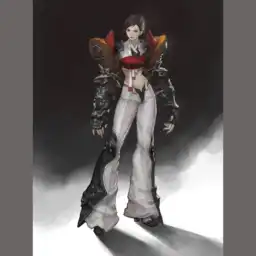
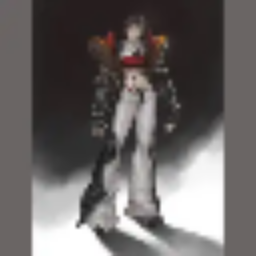
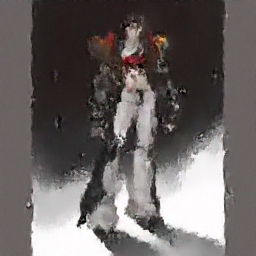

EDM Epoch 27 Loss: 0.0781:  89%|████████▉ | 1433/1602 [04:56<00:34,  4.83it/s]


✅ Saved checkpoint: checkpoints/UNetSR3_2025-09-14_17-32-01_fantasy.pth


'checkpoints/UNetSR3_2025-09-14_17-32-01_fantasy.pth'

In [ ]:
def train_some_sr(model, optimizer,experiment_name):
    model_edm = model #UNet128(use_attention=True).to(device)
    optimizer_edm = optimizer# optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 128
    train_dataset,paired_dataset = get_datasets(experiment_name)
    train_loader = DataLoader(paired_dataset, batch_size=8, shuffle=True)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume:=False:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=diffusion_weights)
    
    t0 = time.time()
    display_interval = 60
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    os.makedirs("outputs", exist_ok=True)
    html_path = f"outputs/SR_{experiment_name}_{timestamp}.html"
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        if not os.path.exists("/tmp/training_running.txt"):
            break
        pbar = tqdm(train_loader)
        for x in pbar:
            hr,lr = x
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            if time.time() > next_checkpoint_time:
                save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag="SR_"+experiment_name)
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:
                with torch.no_grad():
                    next_display_time = next_display_time + 30
                    lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bilinear', align_corners=False).cuda()
                    out = edm_ancestral_sampling(model, lr_up, num_steps=18,batch_size=8,img_shape=(3,256,256))
                    imgs = [hr[0],lr_up[0],out[0]]
                    dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                    title = f"SR training at {dt} loss {loss}"
                    h = html_for_images((sr_to_pil(i) for i in imgs), title=title)
                    ipd.clear_output(wait=True)
                    ipd.display(ipd.HTML(h))
                    with open(html_path,"a") as f:
                        f.write(h)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")



    path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
    del model_edm,optimizer_edm
    return path

#train_some(experiment_name)
train_some_sr(model, optimizer,experiment_name)

## DEBUG

In [83]:
if render_more := False:
    with torch.no_grad():
        train_dataset,paired_dataset = get_datasets(experiment_name)
        train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
        hr,lr = next(iter(train_loader))
        lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bilinear', align_corners=False).cuda()
        out = edm_ancestral_sampling(model, lr_up, num_steps=18,batch_size=4,img_shape=(3,256,256),headstart_sigma=0.04)
        print(out.shape)
        ipd.clear_output(wait=True)
        imgs = [hr[0],lr_up[0],out[0]]
        title = f"Hmm..."
        h = html_for_images((sr_to_pil(i) for i in imgs), title=title)
        ipd.display(ipd.HTML(h))

In [ ]:
if debug_noise_predictions := False:
    with torch.inference_mode():
        ipd.clear_output(wait=True)
        def centercrop(img):
            return img.crop((128 - 28, 128 - 28, 128 + 28, 128+28))
        tmp=x_noisy - lr_up
        imgs = [
            sr_to_pil(lr_up),
            sr_to_pil(x_noisy),
            sr_to_pil(tmp - noise[0]),
            sr_to_pil(noise_pred[0]),
            sr_to_pil(noise_pred[0] - noise[0]),
            sr_to_pil(lr_up + noise_pred[0] - noise[0]),
            sr_to_pil(lr_up + tmp - noise[0])
        ]
        imgs = [centercrop(i) for i in imgs]
        fig, axes = plt.subplots(1, 10, figsize=(16, 4))
        for ax, img in zip(axes, imgs):
            ax.imshow(img)
            ax.axis('off')
        plt.show()

    ### Sanity Check one step of samplng. 

    # Take one HR-LR pair
    dataloader = train_loader
    hr_sample, lr_sample = next(iter(dataloader))
    hr_sample = hr_sample.cuda()
    lr_sample = lr_sample.cuda()

    # Add only small noise
    noise = torch.randn_like(hr_sample) * 0.1
    t = torch.zeros(hr_sample.size(0), dtype=torch.long).cuda()  # timestep 0

    #x_noisy = q_sample(hr_sample, t, noise)
    lr_up = F.interpolate(lr_sample, size=(256,256), mode='bilinear', align_corners=False)
    x_noisy = q_sample(lr_up,t,noise)
    x_input = torch.cat([x_noisy, lr_up], dim=1)
    with torch.no_grad():
        out = model(x_input, t.float() / timesteps)

    # Show output
    img = sr_to_pil(out)
    img

if sanity_test := False:
    noisy = torch.randn(2, 3, 128, 128)
    cond  = torch.randn(2, 3, 128, 128)
    t     = torch.rand(2)
    sr_model = UNetSR3(in_channels=6, out_channels=3, base_channels=64)
    out = sr_model(noisy, cond, t)
    print(out.shape)  # ✅ [2, 3, 128, 128]


model.eval()
for hr_256, lr_64 in train_loader:
    sr_out = sample_sr(model, lr_64.cuda())  # [B, 3, 256, 256]
    break

#from torchvision.utils import save_image
#save_image((sr_out + 1) / 2, 'sr_sample.png')  # map [-1,1] → [0,1] for saving


from torchvision.utils import make_grid
import torch
from PIL import Image

def compare_lr_sr_hr(lr, sr, hr=None, save_path=None):
    """
    lr:  [B, 3, 64, 64]   low-res input
    sr:  [B, 3, 256, 256] super-res output
    hr:  [B, 3, 256, 256] optional ground-truth high-res
    """

    # Upsample LR to match SR size for visual comparison
    lr_up = torch.nn.functional.interpolate(lr, size=(256,256), mode='bilinear', align_corners=False)

    imgs = []
    for i in range(lr_up.size(0)):
        row = [lr_up[i].cpu(), sr[i].cpu()]
        if hr is not None:
            row.append(hr[i].cpu())
        imgs.append(torch.cat(row, dim=2))  # concatenate horizontally

    # Combine all rows vertically
    grid = torch.cat(imgs, dim=1)  # shape: [3, H*num_samples, W*columns]

    # map [-1,1] → [0,1]
    grid = (grid.clamp(-1, 1) + 1) / 2

    # convert to PIL
    grid = (grid * 255).byte().permute(1,2,0).cpu().numpy()
    img = Image.fromarray(grid)

    if save_path:
        img.save(save_path)

    return img

#compare_lr_sr_hr(lr_64,sr_out,hr_256)
#compare_lr_sr_hr(lr_64.cpu(),sr_out.cpu(),hr_256.cpu())
